Вторая версия эксперимента, Кирилл Климук

Пути к данным:

In [0]:
PATH_TO_TRAIN_CSV = 'drive/My Drive/for_graduate/DS kaggle 2019/train.csv'
PATH_TO_TRAIN_IMAGES = 'drive/My Drive/for_graduate/DS kaggle 2019/train_images'
PATH_TO_TEST_IMAGES = 'drive/My Drive/for_graduate/DS kaggle 2019/test_images'
PATH_TO_SUBMISSION_CSV = 'drive/My Drive/for_graduate/DS kaggle 2019/sample_submission.csv'
PATH_TO_LOG_FILE = 'drive/My Drive/for_graduate/DS kaggle 2019/log.txt'

log_file = open(PATH_TO_LOG_FILE, 'w+')

Необходимые импорты:

In [0]:
import torch
import numpy as np
import math
import pandas as pd

from PIL import Image
import glob

import os
from torchvision import transforms
import time

GPU vs CPU

In [0]:
device = torch.device('cpu')

#if torch.cuda.is_available():
#    torch.set_default_tensor_type('torch.cuda.FloatTensor')

Высчитываем данные из .csv файла в датафрейм:

In [0]:
df = pd.read_csv(PATH_TO_TRAIN_CSV, index_col = 'Image_Label')

Архитектура нейронной сети:

In [0]:
class preUNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = 1)
        self.act1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3, padding = 1)
        self.act2 = torch.nn.ReLU()

        self.pool1 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        
        self.conv3 = torch.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1)
        self.act3 = torch.nn.ReLU()
        
        
        self.final_conv = torch.nn.Conv2d(in_channels = 32, out_channels = 5, kernel_size = 1, padding = 0)
        self.sigm = torch.nn.Sigmoid()
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)

        #print('before pooling: ', x.shape)

        x = self.pool1(x)

        #print('after pooling: ', x.shape)
        
        x = self.conv3(x)
        x = self.act3(x)
        
        x = self.final_conv(x)
        
        x = self.sigm(x)
        
        return x

Эталонная маска по классам (полученная из входного .csv файла) (для функции CrossEntropyLoss)

In [0]:
def get_perfect_class_mask_by_photo_name(photo_name):
    
    mask = (torch.zeros((1, 350 * 525))).long()

    mask[:][:] = 4

    patterns = ['Fish', 'Flower', 'Gravel', 'Sugar']
    
    def update_perfect_tensor_by_pattern(answer, pattern):
        needed_str = df['EncodedPixels'][photo_name + '_' + pattern]
        if type(needed_str) == str:
            val = patterns.index(pattern)
            needed_list = needed_str.split(' ')
            for i in range(0, len(needed_list), 2):
                number_of_starting_pixel = (int(needed_list[i]) // 2100 // 4) * 525 +\
                                            int(needed_list[i]) % 2100 // 4
                count = min(int(needed_list[i + 1]) // 4, 350 * 525 - number_of_starting_pixel)
                answer[0][number_of_starting_pixel : number_of_starting_pixel + count] = val
            
    
    update_perfect_tensor_by_pattern(mask, 'Fish')
    update_perfect_tensor_by_pattern(mask, 'Flower')
    update_perfect_tensor_by_pattern(mask, 'Gravel')
    update_perfect_tensor_by_pattern(mask, 'Sugar')
    
    return mask.reshape((350, 525))

Создание экземпляра нейронной сети и оптимизатор:

In [0]:
instance = preUNet()

optimizer = torch.optim.Adam(instance.parameters(), lr = 0.001)

Лосс функция - pixel-wise cross-entropy loss:

In [0]:
loss = torch.nn.CrossEntropyLoss()

Процесс тренировки

In [0]:
BATCH_SIZE = 20
TRAIN_DATA_SET_SIZE = 20
NUMBER_OF_ERAS = 100

In [0]:
epoch_list = []
loss_values_list = []

photoname_train_list = os.listdir(PATH_TO_TRAIN_IMAGES)
photoname_train_list = photoname_train_list[:TRAIN_DATA_SET_SIZE]

print(photoname_train_list)

start_learning = time.time()

for epoch in range(NUMBER_OF_ERAS):

    print('epoch #' + str(epoch) + ' is started, time = ' + str(time.time() - start_learning) + ' s')

    permutation = np.random.permutation(len(photoname_train_list))
    
    #batch
    for batch_index in range(0, len(photoname_train_list), BATCH_SIZE):
        
        optimizer.zero_grad()
        
        #batch_list = photoname_train_list[batch_index : batch_index + BATCH_SIZE]
        batch_list = [photoname_train_list[i] for i in permutation[batch_index : batch_index + BATCH_SIZE]]
        
        # perfect
        perfect_tensor = torch.zeros((len(batch_list), 350, 525))
        perfect_tensor = perfect_tensor.long() ## why
        
        for i, photoname in enumerate(batch_list):
            
            print(i, photoname, file = log_file)

            perfect_tensor[i] = get_perfect_class_mask_by_photo_name(photoname)

            
        print('perfect - done!', file=log_file)
            
        #predicted
        predicted_tensor_args = torch.zeros((len(batch_list), 3, 700, 1050))
        
        for i, photoname in enumerate(batch_list):
            
            print(i, photoname, file=log_file)
            im = Image.open(PATH_TO_TRAIN_IMAGES + '/' + photoname)
            im = im.resize((1050, 700))
            
            tens_operator = transforms.ToTensor()
            
            predicted_tensor_args[i][0] = tens_operator(im)[0]
            predicted_tensor_args[i][1] = tens_operator(im)[1]
            predicted_tensor_args[i][2] = tens_operator(im)[2]

            im.close()
            
        print('predicted args - done!', file=log_file)
        
        predicted_tensor_values = instance.forward(predicted_tensor_args)

        #print(predicted_tensor_values)
        #print(perfect_tensor)
        
        print('predicted values - done!', file=log_file)
        
        loss_value = loss(predicted_tensor_values, perfect_tensor)

        print('loss_value = ', loss_value)

        epoch_list.append(epoch)
        loss_values_list.append(loss_value)
        
        print('loss - done!', file=log_file)

        loss_value.backward()
        
        print('backward - done!', file=log_file)

        optimizer.step()
        
        print('optimizer step - done!', file=log_file)
        

['d24e67f.jpg', 'd22eb33.jpg', 'd2041d7.jpg', 'd265d38.jpg', 'd21b166.jpg', 'd27e37b.jpg', 'd2b4399.jpg', 'd2a42ee.jpg', 'd2e0f14.jpg', 'd2a540d.jpg', 'd2b72aa.jpg', 'd2eb9fe.jpg', 'd29a30a.jpg', 'd2e7aa7.jpg', 'd2c4532.jpg', 'd2c5a99.jpg', 'd314a09.jpg', 'd31f11f.jpg', 'd31af98.jpg', 'd35d04f.jpg']
epoch #0 is started, time = 0.0004253387451171875 s
loss_value =  tensor(1.5485, grad_fn=<NllLoss2DBackward>)
epoch #1 is started, time = 18.023037910461426 s
loss_value =  tensor(1.5479, grad_fn=<NllLoss2DBackward>)
epoch #2 is started, time = 36.04644274711609 s
loss_value =  tensor(1.5509, grad_fn=<NllLoss2DBackward>)
epoch #3 is started, time = 54.161821365356445 s
loss_value =  tensor(1.5530, grad_fn=<NllLoss2DBackward>)
epoch #4 is started, time = 72.22925615310669 s
loss_value =  tensor(1.5551, grad_fn=<NllLoss2DBackward>)
epoch #5 is started, time = 90.32185864448547 s
loss_value =  tensor(1.5535, grad_fn=<NllLoss2DBackward>)
epoch #6 is started, time = 108.3658185005188 s
loss_valu

Построим график loss-функции от числа эпох:

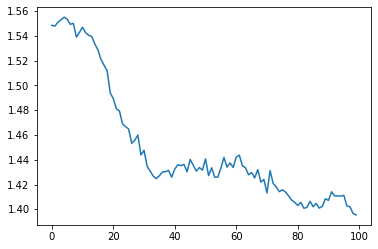

In [0]:
import matplotlib.pyplot as plt

plt.plot(epoch_list, loss_values_list)
plt.show()

Процесс тестирования:



Выходной .csv файл:

In [0]:
f = open(PATH_TO_SUBMISSION_CSV, 'w+')
f.close()

submission_df = pd.DataFrame(columns = ['Image_Label', 'EncodedPixels'])
submission_df = submission_df.set_index('Image_Label')


Вспомогательные функции:

Перевод выходного тензора в предсказанную маску паттернов:

In [0]:
def nn_predicted_mask_to_pattern_mask(tens):

    if tens.shape != torch.Size([1, 5, 350, 525]):
      raise ValueError('incorrect input shape!')

    return torch.argmax(tens, dim = 1).resize_(350, 525)    

Получение строк для .csv файла из маски паттернов:

In [0]:
def get_strings_from_pattern_mask(pattern_mask):

    def get_pattern_str(pattern_val_in_mask):
      answer_list = []
      count = 0
      for h in range(350):
        for w in range(525):
          if pattern_mask[h][w] == pattern_val_in_mask:
            count += 1
          else:
            if count != 0:
              answer_list.append(str(525 * h + w - count))
              answer_list.append(str(count))
              count = 0
      if count != 0:
        answer_list.append(str(525 * 350 - count))
        answer_list.append(str(count))
      
      return ' '.join(answer_list)

    #fish, flower, gravel, sugar
    return get_pattern_str(0), get_pattern_str(1), get_pattern_str(2), get_pattern_str(3)  
              
              



Сам процесс тестирования:

In [0]:
NUMBER_OF_PROCESSED_TEST_IMAGES = 10

In [0]:
photoname_test_list = os.listdir(PATH_TO_TEST_IMAGES)
photoname_test_list = photoname_test_list[:NUMBER_OF_PROCESSED_TEST_IMAGES]

for test_image_photoname in photoname_test_list:

    print(test_image_photoname)

    im = Image.open(PATH_TO_TEST_IMAGES + '/' + test_image_photoname)
    im = im.resize((1050, 700))

    to_tensor = transforms.ToTensor()

    predicted_tensor_from_nn = instance.forward(to_tensor(im).resize_(1, 3, 700, 1050))

    #print(predicted_tensor_from_nn[0][0])
    #print(predicted_tensor_from_nn[0][1])
    #print(predicted_tensor_from_nn[0][2])
    #print(predicted_tensor_from_nn[0][3])
    #print(predicted_tensor_from_nn[0][4])

    #print(nn_predicted_mask_to_pattern_mask(predicted_tensor_from_nn))

    fish_str, flower_str, gravel_str, sugar_str = get_strings_from_pattern_mask(nn_predicted_mask_to_pattern_mask(predicted_tensor_from_nn))

    submission_df.loc[test_image_photoname + '_Fish'] = fish_str
    submission_df.loc[test_image_photoname + '_Flower'] = flower_str
    submission_df.loc[test_image_photoname + '_Gravel'] = gravel_str
    submission_df.loc[test_image_photoname + '_Sugar'] = sugar_str


bc3ca7f.jpg
bbd680d.jpg
bbe5085.jpg
bc7ea95.jpg
bc354be.jpg
bc9017f.jpg
bcf66d6.jpg
bce3c05.jpg
bd237a7.jpg
bcf4c08.jpg


Записать получившийся выходной датафрейм в .csv файл:

In [0]:
submission_df.to_csv(PATH_TO_SUBMISSION_CSV)